In [ ]:
!pip install torch torchvision matplotlib


In [12]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [11]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
import matplotlib.pyplot as plt
from google.colab import drive
import os
import zipfile
import shutil
import pandas as pd
import torch.optim as optim
from torch.utils.data import random_split
import cv2
import numpy as np
from PIL import Image



In [13]:
#check device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [14]:
#dataset drive path

dataset_path = "/content/drive/MyDrive/trafficsign_dataset/archive.zip"
os.path.exists(dataset_path)


True

In [15]:
#extract dataset

zip_path = "/content/drive/MyDrive/trafficsign_dataset/archive.zip"
extract_path = "/content/trafficsign_dataset"

# Check if ZIP exists
if not os.path.exists(zip_path):
    raise FileNotFoundError(f"ZIP file not found at {zip_path}")

# Create extraction folder if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Extract the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted successfully!")
print("Contents:", os.listdir(extract_path))


Dataset extracted successfully!
Contents: ['Train', 'Meta', 'test', 'train', 'Train.csv', 'Test.csv', 'meta', 'Meta.csv', 'Test']


In [17]:
#contents of dataset
train_path = "/content/trafficsign_dataset/Train"
test_path  = "/content/trafficsign_dataset/Test"


print("Contents of dataset folder:", os.listdir('/content/trafficsign_dataset'))
print("Contents of Train folder:", os.listdir(train_path))
print("Contents of Test folder:", os.listdir(test_path))


Contents of dataset folder: ['Train', 'Meta', 'test', 'train', 'Train.csv', 'Test.csv', 'meta', 'Meta.csv', 'Test']
Contents of Train folder: ['28', '12', '27', '22', '8', '7', '30', '25', '18', '21', '14', '26', '16', '11', '32', '36', '31', '3', '41', '29', '20', '4', '5', '9', '33', '19', '37', '0', '6', '35', '10', '34', '15', '38', '42', '23', '1', '24', '17', '2', '13', '40', '39']
Contents of Test folder: ['09353.png', '01605.png', '00631.png', '02718.png', '06846.png', '05454.png', '08318.png', '11580.png', '00150.png', '01723.png', '05189.png', '06125.png', '02578.png', '00440.png', '01878.png', '07585.png', '05585.png', '07955.png', '06310.png', '01680.png', '03832.png', '06994.png', '00764.png', '02291.png', '06805.png', '08504.png', '09338.png', '01032.png', '06718.png', '04874.png', '08678.png', '02057.png', '05301.png', '06354.png', '09663.png', '11751.png', '08063.png', '09939.png', '09053.png', '09973.png', '04589.png', '03338.png', '01287.png', '00312.png', '00971.png'

In [18]:
#check to see that Test folder contain images not classes -> error for ImageFolder
# Path to your Test.csv
csv_file = "/content/trafficsign_dataset/Test.csv"

# Load the CSV
df = pd.read_csv(csv_file)

# Display the first few rows
print(df.head())

# Display column names
print("Columns in CSV:", df.columns.tolist())


   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId            Path
0     53      54       6       5      48      49       16  Test/00000.png
1     42      45       5       5      36      40        1  Test/00001.png
2     48      52       6       6      43      47       38  Test/00002.png
3     27      29       5       5      22      24       33  Test/00003.png
4     60      57       5       5      55      52       11  Test/00004.png
Columns in CSV: ['Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'ClassId', 'Path']


In [19]:
#convert Test images to their classes

# Paths
test_folder = "/content/trafficsign_dataset/Test"
csv_file = "/content/trafficsign_dataset/Test.csv"

# Load CSV
df = pd.read_csv(csv_file)

# Create class subfolders and move images
for _, row in df.iterrows():
    filename = os.path.basename(row['Path'])  # extract filename from Path
    class_label = str(row['ClassId'])
    class_folder = os.path.join(test_folder, class_label)

    # Create class folder if it doesn't exist
    os.makedirs(class_folder, exist_ok=True)

    # Move the image into the class folder
    src = os.path.join(test_folder, filename)
    dst = os.path.join(class_folder, filename)

    if os.path.exists(src):
        shutil.move(src, dst)

print("Test folder fixed: images organized into class subfolders.")


Test folder fixed: images organized into class subfolders.


In [20]:
#preprocessing ,augmentation and dataloader

transform_train = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # CV technique – improves generalization
    transforms.RandomRotation(15),                         # CV technique – rotation augmentation
    transforms.RandomHorizontalFlip(),                     # CV technique – flip augmentation
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

train_path = "/content/trafficsign_dataset/Train"
test_path  = "/content/trafficsign_dataset/Test"

# Load datasets
train_dataset = torchvision.datasets.ImageFolder(root=train_path, transform=transform_train)
test_dataset  = torchvision.datasets.ImageFolder(root=test_path, transform=transform_test)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Training samples:", len(train_dataset))
print("Testing samples:", len(test_dataset))


Training samples: 39209
Testing samples: 12630


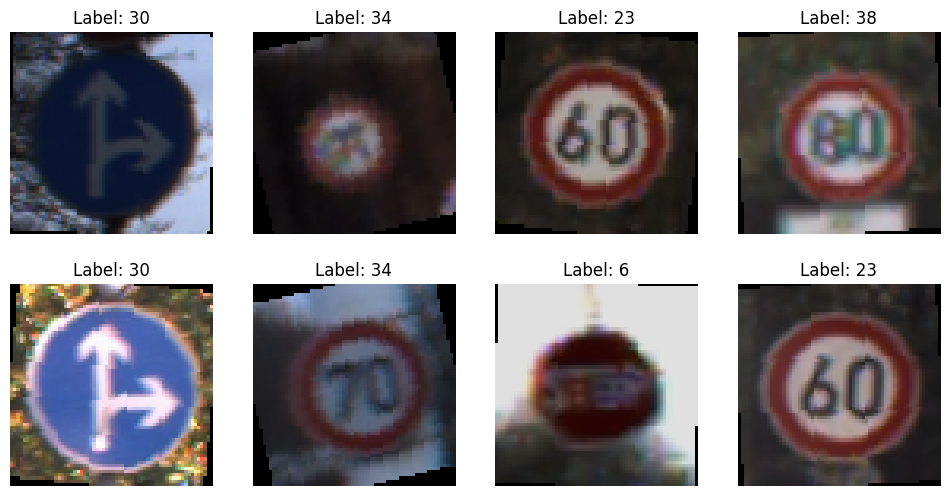

In [23]:
#sample batch
images, labels = next(iter(train_loader))

plt.figure(figsize=(12, 6))
for i in range(8):
    img = images[i].permute(1, 2, 0) * 0.5 + 0.5  # unnormalize
    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.title(f"Label: {labels[i].item()}")
    plt.axis("off")
plt.show()


# **CNN Model**

In [ ]:
#CNN Model

class TrafficSignCNNEnhanced(nn.Module):
    def __init__(self, num_classes):
        super(TrafficSignCNNEnhanced, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2),        # 64x64 -> 32x32


            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2),        # 32x32 -> 16x16


            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2,2),        # 16x16 -> 8x8


            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2,2),        # 8x8 -> 4x4
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256*4*4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x
